In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 12.3 MB/s eta 0:00:00


In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler
import joblib
import optuna
import cv2
import xgboost as xgb
from xgboost import XGBRegressor
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# All dataset generic path
DATASET_DIR = Path('/content/drive/MyDrive/hyperview/eotdl/datasets/HYPERVIEW2/')

In [ ]:
# Dataset paths for airborne and satellite

#HSI_AIRBORNE_DIR = DATASET_DIR / 'train' / 'hsi_airborne'
HSI_SATELLITE_TRAIN_DIR = DATASET_DIR / 'train' / 'hsi_satellite'
MSI_SATELLITE_TRAIN_DIR = DATASET_DIR / 'train' / 'msi_satellite'

HSI_SATELLITE_TEST_DIR = DATASET_DIR / 'test' / 'hsi_satellite'
MSI_SATELLITE_TEST_DIR = DATASET_DIR / 'test' / 'msi_satellite'

GT_TRAIN_CSV_PATH = DATASET_DIR / 'train_gt.csv'

RESULTS = Path("/content/drive/MyDrive/hyperview/results/")
RESULTS.mkdir(exist_ok=True)

In [ ]:
# %% Load the ground truth measurements
gt_train_df = pd.read_csv(GT_TRAIN_CSV_PATH)
gt_train_df.head()

,sample_index,B,Cu,Zn,Fe,S,Mn
0,0,0.8,2.1,5.0,186.6,12.078640,110.7
1,1,0.6,3.5,7.3,255.6,12.199673,75.7
2,2,0.5,2.1,2.3,204.0,65.882013,87.1
3,3,0.8,1.9,3.3,165.6,31.942712,56.0
4,4,0.5,2.4,5.8,419.9,35.970698,65.1


In [ ]:
column_names = ['B', 'Cu', 'Zn', 'Fe', 'S', 'Mn']

In [ ]:
# Initialize lists to store data
hsi_train_data = []

# Loop through indices 0000 to 1875
for i in range(1876):
    file_name = f"{i:04d}.npz"

    # Load HSI airborne
    file_path = HSI_SATELLITE_TRAIN_DIR / file_name
    if file_path.exists():
        with np.load(file_path) as npz:
            arr = np.ma.MaskedArray(**npz)
            hsi_train_data.append(arr)
    else:
        print(f"HSI file {file_name} not found.")
        hsi_train_data.append(None)  # Placeholder for missing files

In [ ]:
# Verify the number of loaded files
print(f"Loaded {len([x for x in hsi_train_data if x is not None])} HSI files")

Loaded 1876 HSI files


In [ ]:
# Define water absorption bands
WATER_BANDS = list(range(95, 120)) + list(range(140,180))  # water-bands wavelength numbers
KEEP_BANDS = [i for i in range(230) if i not in WATER_BANDS]  # Bands to keep

In [ ]:
# Initialize lists to store data
hsi_train_data_rwb = []

# Load and process all .npz files
for i in range(1876):
    file_name = f"{i:04d}.npz"

    # Load HSI airborne (HySpex VS-725)
    file_path = HSI_SATELLITE_TRAIN_DIR / file_name
    if file_path.exists():
        with np.load(file_path) as npz:
            arr = np.ma.MaskedArray(**npz)
            # Remove water bands
            arr_filtered = arr[KEEP_BANDS, :, :]
            hsi_train_data_rwb.append(arr_filtered)
            print(f"HSI {file_name}: original shape {arr.shape}, filtered shape {arr_filtered.shape}")
    else:
        print(f"HSI file {file_name} not found.")
        hsi_train_data_rwb.append(None)

HSI 0000.npz: original shape (230, 2, 2), filtered shape (165, 2, 2)
HSI 0001.npz: original shape (230, 3, 3), filtered shape (165, 3, 3)
HSI 0002.npz: original shape (230, 2, 2), filtered shape (165, 2, 2)
HSI 0003.npz: original shape (230, 2, 2), filtered shape (165, 2, 2)
HSI 0004.npz: original shape (230, 2, 2), filtered shape (165, 2, 2)
HSI 0005.npz: original shape (230, 2, 2), filtered shape (165, 2, 2)
HSI 0006.npz: original shape (230, 2, 2), filtered shape (165, 2, 2)
HSI 0007.npz: original shape (230, 2, 2), filtered shape (165, 2, 2)
HSI 0008.npz: original shape (230, 2, 2), filtered shape (165, 2, 2)
HSI 0009.npz: original shape (230, 3, 3), filtered shape (165, 3, 3)
HSI 0010.npz: original shape (230, 3, 2), filtered shape (165, 3, 2)
HSI 0011.npz: original shape (230, 2, 2), filtered shape (165, 2, 2)
HSI 0012.npz: original shape (230, 2, 2), filtered shape (165, 2, 2)
HSI 0013.npz: original shape (230, 1, 2), filtered shape (165, 1, 2)
HSI 0014.npz: original shape (230,

In [ ]:
# Verify the number of loaded files
print(f"Loaded {len([x for x in hsi_train_data_rwb if x is not None])} HSI-RWB files")

Loaded 1876 HSI-RWB files


In [ ]:
# Shape check hsi
hsi_train_data[5].shape, hsi_train_data[50].shape, hsi_train_data[500].shape, hsi_train_data[15].shape

((230, 2, 2), (230, 2, 2), (230, 2, 2), (230, 2, 3))

In [ ]:
# Shape check hsi-rwb
hsi_train_data_rwb[5].shape, hsi_train_data_rwb[50].shape, hsi_train_data_rwb[500].shape, hsi_train_data_rwb[15].shape

((165, 2, 2), (165, 2, 2), (165, 2, 2), (165, 2, 3))

In [ ]:
# Shape check GT
gt_train_df.shape

(1876, 7)

In [ ]:
# 1. Prepare your data
# X = np.stack([arr.mean(axis=(1, 2)) for arr in hsi_train_data_rwb])  # shape: (1876, 230)

# Convert each masked array to a regular array before stacking
X = np.stack([np.asarray(arr.mean(axis=(1, 2))) for arr in hsi_train_data_rwb])
C_ref = gt_train_df.values  # shape: (1876, 7)

X.shape, C_ref.shape

In [ ]:
# Remove the index column
C_ref = gt_train_df.values  # shape: (1876, 7)
C_ref = C_ref[:, 1:]
C_ref[:,0], C_ref.shape

In [ ]:
# Gram Schmidt Pansharpening
def gram_schmidt_pansharpen(hsi, msi):
    """
    Perform Gram-Schmidt pansharpening.
    hsi: (C_h, H, W) - low spatial resolution HSI cube
    msi: (C_m, h, w) - high spatial resolution MSI cube
    Returns:
        pansharpened_hsi: (C_h, H, W)
    """
    hsi = np.asarray(hsi)
    msi = np.asarray(msi)

    C_h, H, W = hsi.shape
    C_m, h, w = msi.shape

    # Upsample MSI to match HSI resolution (if needed)
    msi_upsampled = np.stack([
        cv2.resize(msi[b], (W, H), interpolation=cv2.INTER_CUBIC)
        for b in range(C_m)
    ])

    # Simulated PAN from MSI
    pan = msi_upsampled.mean(axis=0)  # shape (H, W)

    # Flatten HSI and PAN
    hsi_2d = hsi.reshape(C_h, -1)           # (C_h, H*W)
    pan_flat = pan.flatten()[None, :]       # (1, H*W)

    # Stack PAN + HSI
    X = np.vstack([pan_flat, hsi_2d])       # (1 + C_h, H*W)

    # Gram-Schmidt orthogonalization
    Q = np.zeros_like(X)
    R = np.zeros((X.shape[0], X.shape[0]))

    for i in range(X.shape[0]):
        v = X[i]
        for j in range(i):
            R[j, i] = np.dot(Q[j], X[i])
            v = v - R[j, i] * Q[j]
        R[i, i] = np.linalg.norm(v) + 1e-8
        Q[i] = v / R[i, i]

    # Inject MSI PAN into first GS component
    Q[0] = pan_flat  # replace with real PAN

    # Reconstruct fused data
    fused_2d = np.dot(R.T, Q)

    # Extract fused HSI bands
    fused_hsi = fused_2d[1:].reshape(C_h, H, W)

    return fused_hsi

In [ ]:
"""
    Perform Bayesian Sparse Representation (BSR) pansharpening for HSI and MSI fusion.

    Args:
        hsi: (C_h, H, W) - low spatial resolution HSI cube
        msi: (C_m, h, w) - high spatial resolution MSI cube
        weights: (C_m,) - optional weights for MSI bands to simulate PAN (default: equal weights)
        alpha: float - regularization parameter for sparse coding
        dict_size: int - number of dictionary atoms for sparse representation

    Returns:
        pansharpened_hsi: (C_h, H, W) - fused HSI cube with enhanced spatial and spectral properties
    """


import numpy as np
import cv2
from scipy.sparse.linalg import svds
from sklearn.linear_model import Lasso

def bsr_pansharpen(hsi, msi, weights=None, alpha=0.1, dict_size=256):

    hsi = np.asarray(hsi, dtype=np.float32)
    msi = np.asarray(msi, dtype=np.float32)

    C_h, H, W = hsi.shape
    C_m, h, w = msi.shape

    # Normalize inputs to ensure radiometric consistency
    hsi = (hsi - hsi.min()) / (hsi.max() - hsi.min() + 1e-8)
    msi = (msi - msi.min()) / (msi.max() - msi.min() + 1e-8)

    # Upsample MSI to match HSI resolution using Lanczos interpolation
    msi_upsampled = np.stack([
        cv2.resize(msi[b], (W, H), interpolation=cv2.INTER_LANCZOS4)
        for b in range(C_m)
    ])

    # Simulate PAN band with weighted combination of MSI bands
    if weights is None:
        weights = np.ones(C_m) / C_m
    else:
        weights = np.asarray(weights) / np.sum(weights)
    pan = np.sum(msi_upsampled * weights[:, None, None], axis=0)

    # Apply light Gaussian blur to PAN to improve SNR
    pan = cv2.GaussianBlur(pan, (3, 3), sigmaX=0.5)

    # Flatten HSI and PAN for sparse representation
    hsi_2d = hsi.reshape(C_h, -1).T  # (H*W, C_h)
    pan_flat = pan.flatten()         # (H*W,)

    # Learn dictionary from MSI data using SVD
    msi_2d = msi_upsampled.reshape(C_m, -1).T  # (H*W, C_m)
    D, _, _ = svds(msi_2d, k=min(dict_size, min(msi_2d.shape)))  # Dictionary: (H*W, dict_size)

    # Sparse coding for HSI using Lasso regression
    lasso = Lasso(alpha=alpha, fit_intercept=False)
    sparse_codes = np.zeros((H * W, D.shape[1]))
    for i in range(H * W):
        lasso.fit(D, hsi_2d[i])
        sparse_codes[i] = lasso.coef_

    # Bayesian update: Combine sparse codes with PAN information
    pan_codes = np.zeros((H * W, D.shape[1]))
    lasso.fit(D, pan_flat)
    pan_codes = lasso.coef_

    # Fuse by combining sparse codes with Bayesian weighting
    sigma_hsi = np.var(hsi_2d, axis=0) + 1e-8
    sigma_pan = np.var(pan_flat) + 1e-8
    fused_codes = (sigma_pan * sparse_codes + sigma_hsi.mean() * pan_codes[:, None]) / (sigma_pan + sigma_hsi.mean())

    # Reconstruct fused HSI
    fused_2d = np.dot(fused_codes, D.T).T  # (C_h, H*W)
    fused_hsi = fused_2d.reshape(C_h, H, W)

    # Post-process: Clip to ensure radiometric consistency
    fused_hsi = np.clip(fused_hsi, 0, 1)

    return fused_hsi

In [ ]:
# Initialize lists to store data
msi_train_data = []

# Loop through indices 0000 to 1875
for i in range(1876):
    file_name = f"{i:04d}.npz"

    # Load HSI airborne
    file_path = MSI_SATELLITE_TRAIN_DIR / file_name
    if file_path.exists():
        with np.load(file_path) as npz:
            arr = np.ma.MaskedArray(**npz)
            msi_train_data.append(arr)
    else:
        print(f"MSI file {file_name} not found.")
        msi_train_data.append(None)  # Placeholder for missing files

In [ ]:
# Verify the number of loaded files
print(f"Loaded {len([x for x in msi_train_data if x is not None])} MSI files")

Loaded 1876 MSI files


In [ ]:
msi_train_data[5].shape

(12, 3, 2)

In [ ]:
"""
    Array of HSI data-only
                            """
X_hsi = np.stack([np.asarray(arr.mean(axis=(1, 2))) for arr in hsi_train_data_rwb])

In [ ]:
"""
    Array of MSI data-only
                            """
X_msi = np.stack([np.asarray(arr.mean(axis=(1, 2))) for arr in msi_train_data])

In [ ]:
X_hsi.shape, X_msi.shape

((1876, 165), (1876, 12))

In [ ]:
X_fused = fuse_cnmf(X_hsi, X_msi)

Epoch 10 reached after 0.058 seconds, error: 32.452492
Epoch 20 reached after 0.102 seconds, error: 20.694479
Epoch 30 reached after 0.130 seconds, error: 15.732607
Epoch 40 reached after 0.157 seconds, error: 13.079615
Epoch 50 reached after 0.182 seconds, error: 11.415691
Epoch 60 reached after 0.206 seconds, error: 10.317905
Epoch 70 reached after 0.224 seconds, error: 9.573925
Epoch 80 reached after 0.248 seconds, error: 9.039078
Epoch 90 reached after 0.277 seconds, error: 8.633393
Epoch 100 reached after 0.297 seconds, error: 8.315299
Epoch 110 reached after 0.317 seconds, error: 8.060110
Epoch 120 reached after 0.343 seconds, error: 7.851240
Epoch 130 reached after 0.362 seconds, error: 7.677009
Epoch 140 reached after 0.380 seconds, error: 7.529151
Epoch 150 reached after 0.414 seconds, error: 7.401820
Epoch 160 reached after 0.466 seconds, error: 7.290842
Epoch 170 reached after 0.489 seconds, error: 7.193169
Epoch 180 reached after 0.509 seconds, error: 7.106483
Epoch 190 rea

In [ ]:
X_fused.shape

(1876, 165)

In [ ]:
# Fuse hsi and msi with gram-schmidt function

X_fused_gs = []

for hsi, msi in zip(hsi_train_data_rwb, msi_train_data):
    if hsi is not None and msi is not None:
        try:
            fused_hsi = gram_schmidt_pansharpen(hsi, msi)  # shape (165, H, W)
            # Convert to 1D feature vector
            fused_mean = fused_hsi.mean(axis=(1, 2))  # (165,)
        except Exception as e:
            print("Fusion error:", e)
            fused_mean = np.full(165, np.nan)
    else:
        fused_mean = np.full(165, np.nan)

    X_fused_gs.append(fused_mean)

# Final feature matrix
X = np.stack(X_fused_gs)  # shape (1876, 165)
X = np.nan_to_num(X)      # Clean up NaNs

print("Fused X shape:", X.shape)

**Load pre-processed training data**

In [ ]:
"""
Load pre-processed data
    """
X = np.load('/content/drive/MyDrive/hyperview/processed_data/X1_train_hsi_rwb_msi_gs.npy')
C_ref = np.load('/content/drive/MyDrive/hyperview/processed_data/C_ref.npy')

In [ ]:
"""
Create trials for multi-objective optimization - MSE and R2 with NSGA-III
      """

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna
import joblib
import json
from pathlib import Path

# Define Optuna objective factory using XGBoost and NSGA-III
def make_objective(target_index):
    def objective(trial):
        num_features = X.shape[1]

        # Suggest 14 band indices
        B = [trial.suggest_int(f'B{i+1}', 0, num_features - 1) for i in range(14)]

        # Define band indices
        band_index1 = (X[:, B[0]] - X[:, B[1]]) / (X[:, B[0]] + X[:, B[1]] + 1e-8)
        band_index2 = (X[:, B[2]] - X[:, B[3]]) / (X[:, B[4]] + 1e-8)
        band_index3 = X[:, B[5]] / (X[:, B[6]] - X[:, B[7]] + 1e-8)
        band_index4 = X[:, B[8]] / (X[:, B[9]] + X[:, B[10]] + 1e-8)
        band_index5 = X[:, B[11]]
        band_index6 = X[:, B[12]]
        band_index7 = X[:, B[13]]

        # Combine indices into features
        features = np.stack((band_index1, band_index2, band_index3, band_index4, band_index5, band_index6, band_index7), axis=1)

        # Select target column
        y = C_ref[:, target_index]

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, random_state=42)

        # Clean NaNs/Infs
        X_train = np.nan_to_num(X_train)
        X_test = np.nan_to_num(X_test)
        y_train = np.nan_to_num(y_train)
        y_test = np.nan_to_num(y_test)

        # XGBoost model
        model = XGBRegressor(
            max_depth=trial.suggest_int('max_depth', 3, 8),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3),
            n_estimators=trial.suggest_int('n_estimators', 50, 200),
            subsample=trial.suggest_float('subsample', 0.5, 1.0),
            colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 1.0),
            reg_alpha=trial.suggest_float('reg_alpha', 0, 1.0),
            reg_lambda=trial.suggest_float('reg_lambda', 0, 1.0),
            random_state=42,
            verbosity=0
        )

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Save best model and bands based on MSE
        best_mse = trial.study.user_attrs.get("best_mse", np.inf)
        if mse < best_mse:
            trial.study.set_user_attr("best_mse", mse)
            trial.study.set_user_attr("best_r2", r2)
            joblib.dump(model, RESULTS / f"best_s3_xgb_t500_{target_index}.pkl")

            # Save selected bands
            with open(RESULTS / f"best_s3_bands_t500_{target_index}.json", "w") as f:
                json.dump(B, f)

        return mse, 1 - r2  # Minimize both MSE and 1-R²

    return objective

# Run optimization with NSGA-II sampler for each target
for i in range(C_ref.shape[1]):
    print(f"\n🔍 Optimizing XGBoost model for target index {i}")
    sampler = optuna.samplers.NSGAIIISampler(seed=42)
    study = optuna.create_study(directions=['minimize', 'minimize'], sampler=sampler)  # Minimize MSE and 1-R²
    study.optimize(make_objective(i), n_trials=500)

    # Get Pareto front solutions
    print(f"✅ Number of Pareto front solutions for target {i}: {len(study.best_trials)}")
    for trial in study.best_trials:
        print(f"  Trial {trial.number}: MSE = {trial.values[0]:.4f}, R² = {1 - trial.values[1]:.4f}")

/tmp/ipython-input-14-1513735890.py:82: ExperimentalWarning: NSGAIIISampler is experimental (supported from v3.2.0). The interface can change in the future.
  sampler = optuna.samplers.NSGAIIISampler(seed=42)
[I 2025-07-10 19:54:13,765] A new study created in memory with name: no-name-014c678c-47b8-4493-8dda-5b585b6d3d69



🔍 Optimizing XGBoost model for target index 0


[I 2025-07-10 19:54:14,074] Trial 0 finished with values: [0.02090275426957738, 0.41853545791880076] and parameters: {'B1': 61, 'B2': 156, 'B3': 120, 'B4': 98, 'B5': 25, 'B6': 25, 'B7': 9, 'B8': 142, 'B9': 99, 'B10': 116, 'B11': 3, 'B12': 160, 'B13': 137, 'B14': 35, 'max_depth': 4, 'learning_rate': 0.06318730785749581, 'n_estimators': 95, 'subsample': 0.762378215816119, 'colsample_bytree': 0.7159725093210578, 'reg_alpha': 0.2912291401980419, 'reg_lambda': 0.6118528947223795}.
[I 2025-07-10 19:54:14,149] Trial 1 finished with values: [0.021654970625266463, 0.4335970719444966] and parameters: {'B1': 23, 'B2': 48, 'B3': 60, 'B4': 75, 'B5': 129, 'B6': 32, 'B7': 84, 'B8': 97, 'B9': 7, 'B10': 100, 'B11': 28, 'B12': 10, 'B13': 156, 'B14': 159, 'max_depth': 7, 'learning_rate': 0.09833799306027749, 'n_estimators': 64, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'reg_alpha': 0.12203823484477883, 'reg_lambda': 0.4951769101112702}.
[I 2025-07-10 19:54:14,177] Trial 2 f

✅ Number of Pareto front solutions for target 0: 1
  Trial 320: MSE = 0.0188, R² = 0.6245

🔍 Optimizing XGBoost model for target index 1


[I 2025-07-10 19:55:16,520] Trial 1 finished with values: [0.1711565094350558, 0.7767283706638871] and parameters: {'B1': 23, 'B2': 48, 'B3': 60, 'B4': 75, 'B5': 129, 'B6': 32, 'B7': 84, 'B8': 97, 'B9': 7, 'B10': 100, 'B11': 28, 'B12': 10, 'B13': 156, 'B14': 159, 'max_depth': 7, 'learning_rate': 0.09833799306027749, 'n_estimators': 64, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'reg_alpha': 0.12203823484477883, 'reg_lambda': 0.4951769101112702}.
[I 2025-07-10 19:55:16,569] Trial 2 finished with values: [0.16364440161631935, 0.7426375418338413] and parameters: {'B1': 5, 'B2': 150, 'B3': 42, 'B4': 109, 'B5': 51, 'B6': 85, 'B7': 90, 'B8': 30, 'B9': 159, 'B10': 127, 'B11': 155, 'B12': 147, 'B13': 98, 'B14': 152, 'max_depth': 3, 'learning_rate': 0.0668350301015521, 'n_estimators': 56, 'subsample': 0.6626651653816322, 'colsample_bytree': 0.6943386448447411, 'reg_alpha': 0.2713490317738959, 'reg_lambda': 0.8287375091519293}.
[I 2025-07-10 19:55:16,623] Trial 3 fi

✅ Number of Pareto front solutions for target 1: 1
  Trial 350: MSE = 0.1340, R² = 0.3918

🔍 Optimizing XGBoost model for target index 2


[I 2025-07-10 19:56:05,259] Trial 1 finished with values: [2.6975444576797156, 0.6384118163258635] and parameters: {'B1': 23, 'B2': 48, 'B3': 60, 'B4': 75, 'B5': 129, 'B6': 32, 'B7': 84, 'B8': 97, 'B9': 7, 'B10': 100, 'B11': 28, 'B12': 10, 'B13': 156, 'B14': 159, 'max_depth': 7, 'learning_rate': 0.09833799306027749, 'n_estimators': 64, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'reg_alpha': 0.12203823484477883, 'reg_lambda': 0.4951769101112702}.
[I 2025-07-10 19:56:05,290] Trial 2 finished with values: [2.635673177385361, 0.6237691080959125] and parameters: {'B1': 5, 'B2': 150, 'B3': 42, 'B4': 109, 'B5': 51, 'B6': 85, 'B7': 90, 'B8': 30, 'B9': 159, 'B10': 127, 'B11': 155, 'B12': 147, 'B13': 98, 'B14': 152, 'max_depth': 3, 'learning_rate': 0.0668350301015521, 'n_estimators': 56, 'subsample': 0.6626651653816322, 'colsample_bytree': 0.6943386448447411, 'reg_alpha': 0.2713490317738959, 'reg_lambda': 0.8287375091519293}.
[I 2025-07-10 19:56:05,322] Trial 3 fini

✅ Number of Pareto front solutions for target 2: 1
  Trial 444: MSE = 2.0856, R² = 0.5064

🔍 Optimizing XGBoost model for target index 3


[I 2025-07-10 19:56:41,258] Trial 1 finished with values: [1702.8429070457325, 0.474428342493736] and parameters: {'B1': 23, 'B2': 48, 'B3': 60, 'B4': 75, 'B5': 129, 'B6': 32, 'B7': 84, 'B8': 97, 'B9': 7, 'B10': 100, 'B11': 28, 'B12': 10, 'B13': 156, 'B14': 159, 'max_depth': 7, 'learning_rate': 0.09833799306027749, 'n_estimators': 64, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'reg_alpha': 0.12203823484477883, 'reg_lambda': 0.4951769101112702}.
[I 2025-07-10 19:56:41,288] Trial 2 finished with values: [1761.8474192966987, 0.4908675647091565] and parameters: {'B1': 5, 'B2': 150, 'B3': 42, 'B4': 109, 'B5': 51, 'B6': 85, 'B7': 90, 'B8': 30, 'B9': 159, 'B10': 127, 'B11': 155, 'B12': 147, 'B13': 98, 'B14': 152, 'max_depth': 3, 'learning_rate': 0.0668350301015521, 'n_estimators': 56, 'subsample': 0.6626651653816322, 'colsample_bytree': 0.6943386448447411, 'reg_alpha': 0.2713490317738959, 'reg_lambda': 0.8287375091519293}.
[I 2025-07-10 19:56:41,320] Trial 3 fini

✅ Number of Pareto front solutions for target 3: 1
  Trial 291: MSE = 1444.3271, R² = 0.5976

🔍 Optimizing XGBoost model for target index 4


[I 2025-07-10 19:57:40,774] Trial 1 finished with values: [114.60037082225939, 0.6716362445687755] and parameters: {'B1': 23, 'B2': 48, 'B3': 60, 'B4': 75, 'B5': 129, 'B6': 32, 'B7': 84, 'B8': 97, 'B9': 7, 'B10': 100, 'B11': 28, 'B12': 10, 'B13': 156, 'B14': 159, 'max_depth': 7, 'learning_rate': 0.09833799306027749, 'n_estimators': 64, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'reg_alpha': 0.12203823484477883, 'reg_lambda': 0.4951769101112702}.
[I 2025-07-10 19:57:40,808] Trial 2 finished with values: [111.23620786313687, 0.651919957790901] and parameters: {'B1': 5, 'B2': 150, 'B3': 42, 'B4': 109, 'B5': 51, 'B6': 85, 'B7': 90, 'B8': 30, 'B9': 159, 'B10': 127, 'B11': 155, 'B12': 147, 'B13': 98, 'B14': 152, 'max_depth': 3, 'learning_rate': 0.0668350301015521, 'n_estimators': 56, 'subsample': 0.6626651653816322, 'colsample_bytree': 0.6943386448447411, 'reg_alpha': 0.2713490317738959, 'reg_lambda': 0.8287375091519293}.
[I 2025-07-10 19:57:40,854] Trial 3 fini

✅ Number of Pareto front solutions for target 4: 1
  Trial 462: MSE = 97.3441, R² = 0.4295

🔍 Optimizing XGBoost model for target index 5


[I 2025-07-10 19:58:20,590] Trial 1 finished with values: [261.946455369951, 0.5498789024947403] and parameters: {'B1': 23, 'B2': 48, 'B3': 60, 'B4': 75, 'B5': 129, 'B6': 32, 'B7': 84, 'B8': 97, 'B9': 7, 'B10': 100, 'B11': 28, 'B12': 10, 'B13': 156, 'B14': 159, 'max_depth': 7, 'learning_rate': 0.09833799306027749, 'n_estimators': 64, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'reg_alpha': 0.12203823484477883, 'reg_lambda': 0.4951769101112702}.
[I 2025-07-10 19:58:20,640] Trial 2 finished with values: [291.92370976254017, 0.6128072582990672] and parameters: {'B1': 5, 'B2': 150, 'B3': 42, 'B4': 109, 'B5': 51, 'B6': 85, 'B7': 90, 'B8': 30, 'B9': 159, 'B10': 127, 'B11': 155, 'B12': 147, 'B13': 98, 'B14': 152, 'max_depth': 3, 'learning_rate': 0.0668350301015521, 'n_estimators': 56, 'subsample': 0.6626651653816322, 'colsample_bytree': 0.6943386448447411, 'reg_alpha': 0.2713490317738959, 'reg_lambda': 0.8287375091519293}.
[I 2025-07-10 19:58:20,688] Trial 3 finis

✅ Number of Pareto front solutions for target 5: 1
  Trial 368: MSE = 243.6254, R² = 0.4886


In [ ]:
# Load test data
X_test = np.load('/content/drive/MyDrive/hyperview/processed_data/X1_test_hsi_rwb_msi_gs.npy')

In [ ]:
# Example of loaded band_indices from saved jsons
"""
best_band_indices = [
    [3, 7, 12, 22, 5, 8, 13, 9, 11, 6, 19, 2, 25, 15],  # target 0
    [4, 10, 15, 20, 7, 3, 17, 5, 6, 9, 8, 0, 1, 12],    # target 1
    ...
]
  """

# Load band indices into a list
best_band_indices = []
for i in range(6):  # assuming 6 targets
    json_path = RESULTS / f"best_sub3_bands_t2000_{i}.json"
    with open(json_path, 'r') as f:
        B = json.load(f)
        best_band_indices.append(B)

In [ ]:
NUM_TEST_SAMPLES = 1888
NUM_TARGETS = 6

In [ ]:
# --- Predict using trained models ---
predictions = np.zeros((NUM_TEST_SAMPLES, NUM_TARGETS))

In [ ]:
from joblib import load
model = load("filename.pkl")
model.get_params()

In [ ]:
# --- Predict using xgboost models ---
for t in range(NUM_TARGETS):
    print(f"🔍 Predicting target {t}")
    B = best_band_indices[t]

    band_index1 = (X_test[:, B[0]] - X_test[:, B[1]]) / (X_test[:, B[0]] + X_test[:, B[1]] + 1e-8)
    band_index2 = (X_test[:, B[2]] - X_test[:, B[3]]) / (X_test[:, B[4]] + 1e-8)
    band_index3 = X_test[:, B[5]] / (X_test[:, B[6]] - X_test[:, B[7]] + 1e-8)
    band_index4 = X_test[:, B[8]] / (X_test[:, B[9]] + X_test[:, B[10]] + 1e-8)
    band_index5 = (X_test[:, B[11]]) / (X_test[:, B[12]]+ 1e-8)
    band_index6 = X_test[:, B[13]]
    band_index7 = X_test[:, B[14]]
    band_index8 = X_test[:, B[15]]
    band_index9 = X_test[:, B[16]]
    band_index10 = X_test[:, B[17]]

    features = np.stack((band_index1, band_index2, band_index3, band_index4,
                         band_index5, band_index6, band_index7, band_index8, band_index9, band_index10), axis=1)

    # Clean
    features = np.nan_to_num(features)

    # Load model
    model = joblib.load(RESULTS / f"best_sub3_svr_t2000_{t}.pkl")

    # Predict
    pred = model.predict(features)
    predictions[:, t] = pred

🔍 Predicting target 0
🔍 Predicting target 1
🔍 Predicting target 2
🔍 Predicting target 3
🔍 Predicting target 4
🔍 Predicting target 5


In [ ]:
print(predictions[:,3].min()), print(predictions[:,3].max()), print(C_ref[:,3].min()), print(C_ref[:,3].max())

161.75535595866998
296.77011415893935
97.3
481.7


(None, None, None, None)

In [ ]:
predictions = predictions[:, :6]

# Create the submission DataFrame
submission = pd.DataFrame(data=predictions, columns=column_names)

# Add index label
submission.index.name = "sample_index"

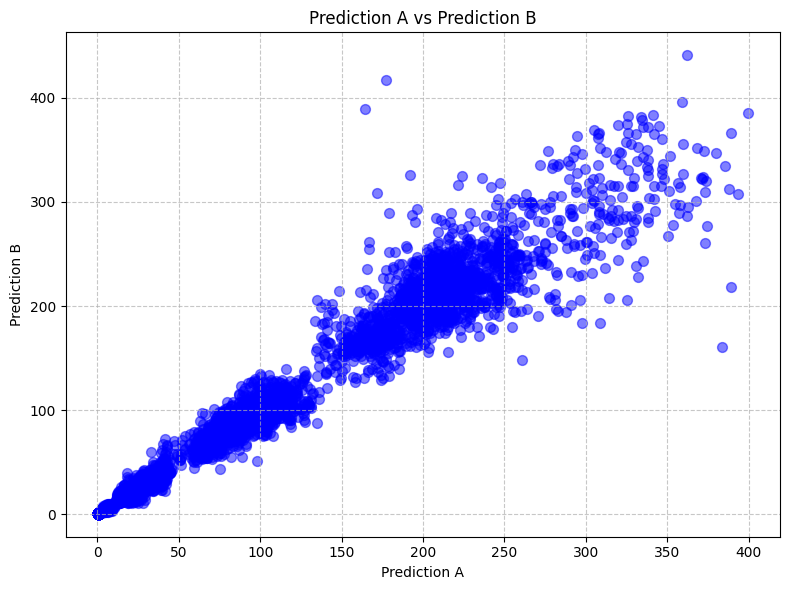

In [ ]:
import matplotlib.pyplot as plt
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(predictions_a, predictions_b, alpha=0.5, s=50, color='blue')
plt.xlabel('Prediction A')
plt.ylabel('Prediction B') #reference
plt.title('Prediction A vs Prediction B')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()